<h1 style="text-align: center;">Dynamic Shifts: Analyzing State Centroid Movement and GDP Trends in the United States (1810-2023)</h1>


The objective of this paper is to define the centers of each state in the United States in the year 1980. The aim is to compare this data with the center of each state in the United States to identify the states that experienced the most significant changes in both size and geometric location over the years. Subsequently, we obtain the Gross Domestic Product (GDP) for each state to explore correlations between the data. In the event that a correlation is found, the paper seeks to determine if there is causation.

In [371]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'scripts'))

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import pandas as pd
import geopandas as gpd

import utils

import warnings

# Suppress the specific UserWarning from geopy
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [362]:
data_file = "united-states-1810.geojson"
data_file_name = data_file.split('.')[1]

PROJECT_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(PROJECT_DIR, 'data', data_file_name)
DATA_FILE = os.path.join(DATA_DIR, data_file)

usa_1980 = gpd.read_file(DATA_FILE)

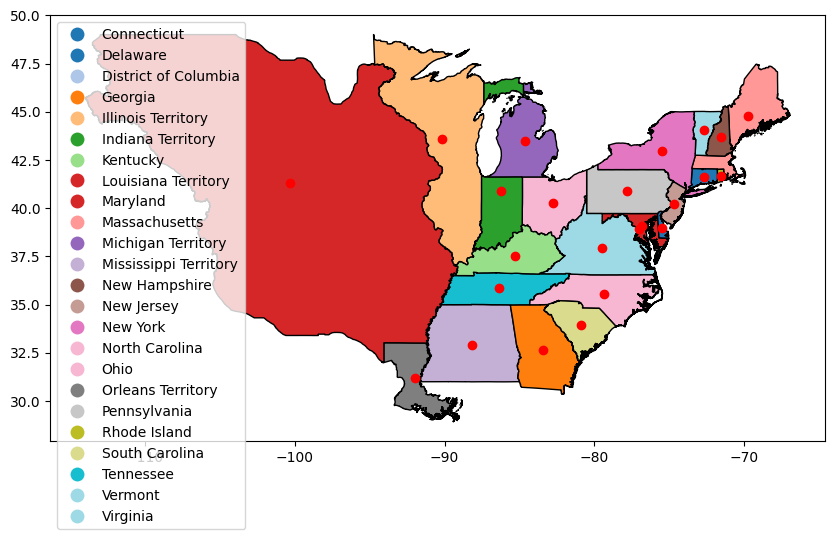

In [363]:
# Create a new column called 'center' which contains the center of each polygon
# target_crs = 'EPSG:3857' 
# usa_1980 = usa_1980.to_crs(target_crs)
usa_1980['center'] = usa_1980['geometry'].centroid

#color different each polygon
usa_1980.plot(
    figsize=(10, 10),
    column='name',
    legend=True,
    cmap='tab20',
    edgecolor='black'
)
plt.scatter(usa_1980.center.x, usa_1980.center.y, color='red')
plt.show()

In this initial graph, we can observe the significant changes that the United States has undergone over the years. With the current context of the states, we can comprehend the major fluctuations that it has experienced due to political, economic, and social decisions.

In [365]:
data_file = "united-states.geojson"
data_file_name = data_file.split('.')[1]

PROJECT_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(PROJECT_DIR, 'data', data_file_name)
DATA_FILE = os.path.join(DATA_DIR, data_file)

usa_currently = gpd.read_file(DATA_FILE)


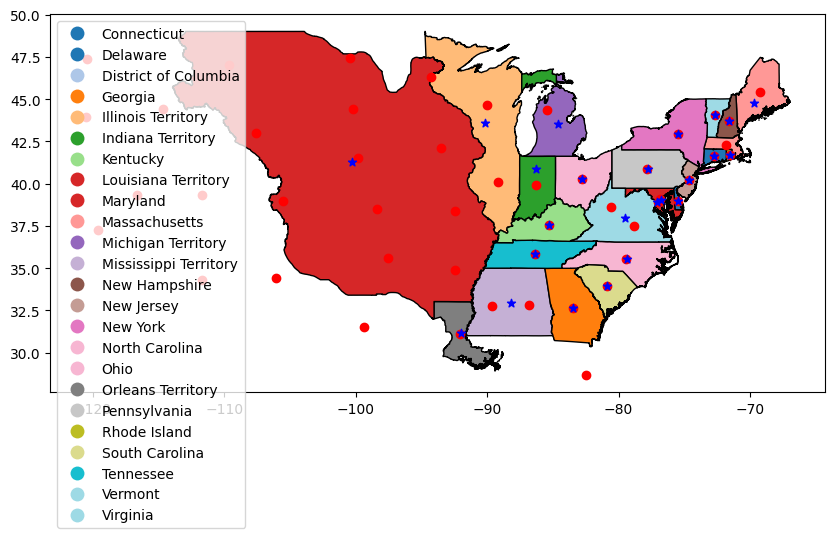

In [366]:
# Create a new column called 'center' which contains the center of each polygon
# target_crs = 'EPSG:3857' 
# usa_currently = usa_currently.to_crs(target_crs)
usa_currently['center'] = usa_currently['geometry'].centroid

#color different each polygon
usa_1980.plot(
    figsize=(10, 10),
    column='name',
    legend=True,
    cmap='tab20',
    edgecolor='black'
)
plt.scatter(usa_currently.center.x, usa_currently.center.y, color='red')
#next scatter with x
plt.scatter(usa_1980.center.x, usa_1980.center.y, color='blue', marker='*')
plt.show()

In this map, we can observe, firstly, how a large number of new states were created with completely different centroids, with Florida and the entire western United States, such as Texas, California, and Arizona, standing out. These were states that did not belong to the United States in 1810. Additionally, some states in the northeastern United States maintain their centroids, such as New York, Pennsylvania, or New Jersey. On the other hand, some states maintain their position but changed in size, causing their centroids to move considerably, as is the case with Virginia and Alabama.

In [367]:
usa_1980.drop(columns=['created_at', 'updated_at', 'cartodb_id'], inplace=True)
usa_currently.drop(columns=['created_at', 'updated_at', 'cartodb_id'], inplace=True)
dataf = usa_currently.merge(usa_1980, on='name', how='left')

In [346]:
def calculate_distance(row):
    if row['center_x'] is not None and row['center_y'] is not None:
        coords_x = (row['center_x'].x, row['center_x'].y)
        coords_y = (row['center_y'].x, row['center_y'].y)
        distance = geodesic(coords_x, coords_y).kilometers
        return distance
    else:
        return None

In [368]:
dataf['distance'] = dataf.apply(calculate_distance, axis=1)
dataf.sort_values(by='distance', ascending=True, inplace=True)

In [384]:
#get data from this website: https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_GDP
url = 'https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_GDP'
df_gdp = pd.read_html(url)[0]

In [385]:
# Select relevant columns
df_gdp = df_gdp[['State or federal district', 'Nominal GDP at current prices 2022 (millions of U.S. dollars)[1]', 'Nominal GDP per capita 2022[1][3]']]

# Rename columns
df_gdp.columns = ['name', 'gdp_2022', 'gdp_2023', 'gdp_per_capita_2022', 'gdp_per_capita_2023']

# Drop unnecessary columns
df_gdp.drop(columns=['gdp_2022', 'gdp_per_capita_2022'], axis=1, inplace=True)

# Remove asterisks from the 'name' column
df_gdp['name'] = df_gdp['name'].str.replace('\*', '')

# Drop the first row
df_gdp.drop(index=[0], inplace=True)

# Clean up special characters in 'gdp_per_capita_2023' column
df_gdp['gdp_per_capita_2023'].replace({'\$': '', ',': ''}, regex=True, inplace=True)

# Remove special characters from 'name' column
df_gdp['name'].replace({'\u202f': ''}, regex=True, inplace=True)

# Convert 'gdp_2023' and 'gdp_per_capita_2023' to float
df_gdp[['gdp_2023', 'gdp_per_capita_2023']] = df_gdp[['gdp_2023', 'gdp_per_capita_2023']].astype(float)

# Sort DataFrame by 'name'
df_gdp.sort_values(by='name', ascending=True, inplace=True)

# Remove special characters from 'name' column again (just in case)
df_gdp['name'].replace({'\u202f': ''}, regex=True, inplace=True)

# Merge with another DataFrame using 'name'
dataf = dataf.merge(df_gdp, on='name', how='left')

dataf[['name', 'distance', 'gdp_2023', 'gdp_per_capita_2023']].dropna().sort_values(by='distance', ascending=True, inplace=True)

df_plot = dataf[dataf['distance'] < 50]

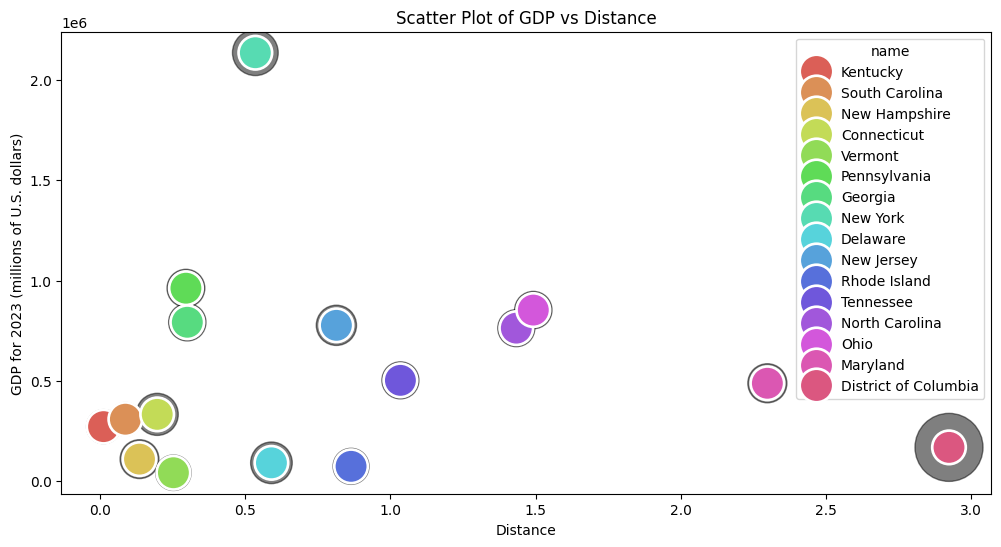

In [387]:
plt.figure(figsize=(12, 6))


plt.title('Scatter Plot of GDP vs Distance')
plt.xlabel('Distance')
plt.ylabel('GDP for 2023 (millions of U.S. dollars)')

# Adjust size for points where distance is less than 50
plt.scatter(
    df_plot['distance'],
    df_plot['gdp_2023'],
    s=df_plot['gdp_per_capita_2023'] / 100,
    color='black',
    alpha=0.5
)

sns.scatterplot(
    data=df_plot,
    x='distance',
    y='gdp_2023',
    hue='name',
    palette='hls',
    s=min(df_plot['gdp_per_capita_2023'] / 100)  # Set a default size for all points
)
plt.show()

In [377]:
# Calculate correlation coefficients
correlation_distance_gdp = df_plot[['distance', 'gdp_2023']].corr().iloc[0, 1]
correlation_distance_gdp_per_capita = df_plot[['distance', 'gdp_per_capita_2023']].corr().iloc[0, 1]

print(f"Correlation between distance and GDP: {correlation_distance_gdp:.2f}")
print(f"Correlation between distance and GDP per capita: {correlation_distance_gdp_per_capita:.2f}")

Correlation between distance and GDP: 0.10
Correlation between distance and GDP per capita: 0.09


In the graph, we can observe that Kentucky is the state that moved the least distance between 1810 and the present day, while the District of Columbia is the state that experienced the greatest movement. Despite highlighting the fact that the centroid that moved the least has the lowest GDP per capita in 2023, and the one that moved the most is precisely the state with the highest GDP per capita in 2023. In the rest of the data, there is no evident correlation or causality among them. Similarly, the distance evidently does not affect any GDP data, demonstrating a correlation between the data of approximately 0.